In [166]:
# import the dataset
import pandas as pd
import numpy as np
master = pd.read_csv('cars.csv')

# Discard any categorical columns (can't easily be quantified)
master.drop(columns=['Engine Information.Engine Type', 'Identification.ID', 'Identification.Model Year'], axis=1, inplace=True)

master.shape

(5076, 15)

In [167]:
# Add features to the data – is the car efficient or not?

# Rename select keys more readable column names

df = master.copy()

df = df.rename(columns=
                       {
                            "Fuel Information.City mpg": "cityMpg",
                            "Fuel Information.Highway mpg": "highwayMpg",
                            "Dimensions.Height": "height",
                            "Dimensions.Length": "length",
                            "Dimensions.Width": "width",
                            "Engine Information.Engine Statistics.Horsepower": "horsepower",
                           "Engine Information.Hybrid": "isHybrid"
                       }
                      )

# Determine whether efficient or not
df['isCityEfficient'] = df.apply(lambda row: (row['cityMpg'] >= 22), axis=1)
df['isHighwayEfficient'] = df.apply(lambda row: (row['highwayMpg'] >= 22), axis=1)
df['isCombinedEfficient'] = df.apply(lambda row: (row['isCityEfficient'] & row['isHighwayEfficient']) , axis=1)

df.tail()

,height,length,width,Engine Information.Driveline,isHybrid,Engine Information.Number of Forward Gears,Engine Information.Transmission,cityMpg,Fuel Information.Fuel Type,highwayMpg,Identification.Classification,Identification.Make,Identification.Year,horsepower,Engine Information.Engine Statistics.Torque,isCityEfficient,isHighwayEfficient,isCombinedEfficient
5071,13,253,201,Front-wheel drive,True,5,5 Speed Automatic,18,Gasoline,25,Automatic transmission,Honda,2012,250,253,False,True,False
5072,141,249,108,All-wheel drive,True,6,6 Speed Manual,12,Gasoline,20,Manual transmission,Lamborghini,2012,552,398,False,False,False
5073,160,249,108,All-wheel drive,True,6,6 Speed Manual,12,Gasoline,20,Manual transmission,Lamborghini,2012,552,398,False,False,False
5074,200,210,110,Rear-wheel drive,True,6,6 Speed Automatic Select Shift,17,Gasoline,25,Automatic transmission,BMW,2012,315,330,False,True,False
5075,200,94,110,Rear-wheel drive,True,6,6 Speed Automatic Select Shift,17,Gasoline,25,Automatic transmission,BMW,2012,315,330,False,True,False


In [168]:
# Determine features to include in dataset

# Remove any unneeded columns
df = df.drop([
    'Engine Information.Driveline',
    'Engine Information.Number of Forward Gears',
    'Engine Information.Transmission',
    'Fuel Information.Fuel Type',
    'Identification.Classification',
    'Identification.Make',
    'Identification.Year',
    'Engine Information.Engine Statistics.Torque'
    ], axis=1)

dataset = df.copy()

dataset.tail()

,height,length,width,isHybrid,cityMpg,highwayMpg,horsepower,isCityEfficient,isHighwayEfficient,isCombinedEfficient
5071,13,253,201,True,18,25,250,False,True,False
5072,141,249,108,True,12,20,552,False,False,False
5073,160,249,108,True,12,20,552,False,False,False
5074,200,210,110,True,17,25,315,False,True,False
5075,200,94,110,True,17,25,315,False,True,False


In [169]:
# Split dataset into training and test set
from sklearn.model_selection import train_test_split

In [170]:

# Define our data and if they are efficient or not

data = dataset[['cityMpg', 'highwayMpg']].to_numpy()

labels = dataset['isCombinedEfficient'].to_numpy()

In [171]:
X_train, X_test, y_train, y_test = train_test_split(
    data, 
    labels, 
    test_size=0.2,
    random_state=42
)

In [172]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 21)

sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=21)

In [173]:
_mpg = data[0]
sgd_clf.predict([_mpg])

array([False])

In [174]:
# Run model on the test data
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([1.       , 0.9992609, 1.       ])

In [175]:
# Evaluate model and make apporpriate changes
from sklearn.model_selection import cross_val_predict

labels_train_predict = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

labels_train_predict

array([ True, False, False, ..., False, False,  True])

In [176]:
# Precision/Recall?

from sklearn.metrics import precision_score, recall_score
precision_score(y_train, labels_train_predict)

0.9985422740524781

In [177]:
recall_score(y_train, labels_train_predict)

1.0

In [178]:
from sklearn.metrics import f1_score
f1_score(y_train, labels_train_predict)

0.99927060539752

In [179]:
# Decide on the threshold
labelsScores = cross_val_predict(sgd_clf, X_train, y_train, cv=3, method='decision_function')

labelsScores

array([ 203.48734016, -298.07384337, -673.41870798, ..., -168.2373948 ,
       -416.13699027,  267.22918889])

In [180]:
# We can use theses cores with precision/recall to plot what the results would be with different thresholds
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train, labelsScores)

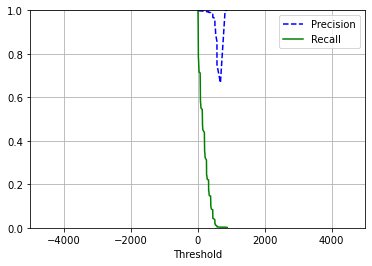

In [181]:
# Plot

import matplotlib as mpl
import matplotlib.pyplot as plt

def plotPrecisionRecallThreshold(pre, rec, thr):
    plt.plot(thr, pre[:-1], 'b--', label='Precision')
    plt.plot(thr, rec[:-1], 'g-', label='Recall')
    plt.grid()
    plt.xlabel('Threshold')
    plt.legend()
    plt.axis([-5000,5000,0,1])
    
plotPrecisionRecallThreshold(precisions, recalls, thresholds)
plt.show()

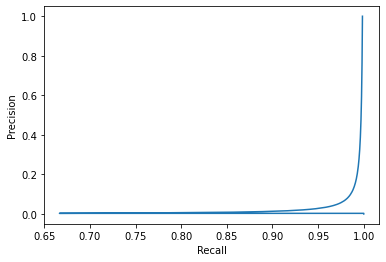

In [182]:
plt.plot(precisions, recalls)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [183]:
# Want 91% precision
threshold91Precision = thresholds[np.argmax(precisions>=.91)]
threshold91Precision

11.58969129257298

In [184]:
labelsTrainPred91 = (labelsScores >= threshold91Precision)
labelsTrainPred91

array([ True, False, False, ..., False, False,  True])

In [185]:
precision_score(y_train, labelsTrainPred91)

0.9985422740524781

In [186]:
recall_score(y_train, labelsTrainPred91)

1.0